In [14]:
import pandas as pd
import numpy as np
import geopandas as gpd
import libpysal
from libpysal.weights import Queen
from spreg import GM_Error_Het
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import torch

# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)

# 固定选取的变量
fixed_columns = [
    'c_percent Aged 10 to 14 years',
    'c_percent Aged 15 to 19 years',
    'c_percent Aged 20 to 24 years',
    'c_percent Aged 25 to 29 years',
    'c_percent Aged 30 to 34 years',
    'c_percent Aged 35 to 39 years',
    'c_percent Aged 40 to 44 years',
    'c_percent Aged 65 to 69 years',
    'c_percent Aged 70 to 74 years',
    'c_percent Aged 75 to 79 years',
    'c_percent Aged 80 to 84 years',
    'c_percent Aged 85 years and over',
    'c_percent mixed',
    'c_percent white',
    'c_percent 2. Professional occupations',
    'c_pop_density',
    'e_ndvi',
    'e_water',
    'e_trees',
    'e_grass',
    'e_bare',
    'c_percent asian',
    'c_percent black',
    'c_percent buddhist',
    'c_percent muslim',
    'c_percent no central heating',
    'c_percent communal heating',
    'c_percent TFW less than 2km',
    'c_percent 49 or more hours worked',
    'c_percent commute on foot',
    'c_percent commute metro rail',
    'c_percent commute bus',
    'c_percent commute bicycle',
    'c_percent student moved to address',
    'c_percent occupancy rating bedrooms -2',
    'c_percent occupancy rating bedrooms -1',
    'c_percent 10 years or more',
    'c_percent 2 years or more but less than 5 years',
    'c_percent 5 years or more but less than 10 years',
    'c_percent married or in a registered civil partnership married same sex',
    'c_percent married or in a registered civil partnership in a registered civil partnership',
    'c_percent separated but still legally married or still legally in a civil partnership separated but still in a registered civil partnership',
    'c_percent divorced or civil partnership dissolved formerly in a civil partnership now legally dissolved',
    'c_percent   cannot speak english well',
    'c_percent   cannot speak english',
    'c_percent households deprived in four dimensions'
]

# 提取固定变量
fixed_features = gdf[fixed_columns].apply(pd.to_numeric, errors='coerce')

# 使用邻接节点的均值填充空值
for i, row in fixed_features.iterrows():
    for col in fixed_columns:
        if pd.isna(row[col]):
            neighbor_indices = list(G.neighbors(i))
            if neighbor_indices:  # 确保有邻居
                neighbor_values = fixed_features.iloc[neighbor_indices][col]
                mean_value = neighbor_values.mean()
                if pd.isna(mean_value):
                    mean_value = fixed_features[col].mean()  # 如果邻居的均值还是nan，使用全局均值填充
                fixed_features.at[i, col] = mean_value
            else:
                fixed_features.at[i, col] = fixed_features[col].mean()  # 如果没有邻居，使用全局均值填充

# 再次检查是否有任何nan值
print("Remaining NaN count:", fixed_features.isna().sum().sum())

# 进行标准化
scaler = StandardScaler()
final_features_scaled = scaler.fit_transform(fixed_features)

# 准备目标变量
target_column = 'o_anxiety_quantity_per_capita'
target = gdf[target_column].apply(pd.to_numeric, errors='coerce').fillna(0).values

# 创建空间权重矩阵
w = Queen.from_dataframe(gdf)

# 构建空间误差模型
model = GM_Error_Het(target, final_features_scaled, w=w)

# 模型预测
predictions = model.predy

# 计算评估指标
mse = mean_squared_error(target, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(target, predictions)
r2 = r2_score(target, predictions)

print(f'Spatial Error Model - MSE: {mse:.4f}')
print(f'Spatial Error Model - RMSE: {rmse:.4f}')
print(f'Spatial Error Model - MAE: {mae:.4f}')
print(f'Spatial Error Model - R²: {r2:.4f}')


Remaining NaN count: 0


C:\Users\0\AppData\Local\Temp\ipykernel_36820\803137685.py:100: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)


Spatial Error Model - MSE: 86.9045
Spatial Error Model - RMSE: 9.3223
Spatial Error Model - MAE: 7.6431
Spatial Error Model - R²: 0.4730


Remaining NaN count: 0


C:\Users\0\AppData\Local\Temp\ipykernel_36820\3255471714.py:100: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)


Spatial Lag Model - MSE: 55.2654
Spatial Lag Model - RMSE: 7.4341
Spatial Lag Model - MAE: 5.7181
Spatial Lag Model - R²: 0.6649


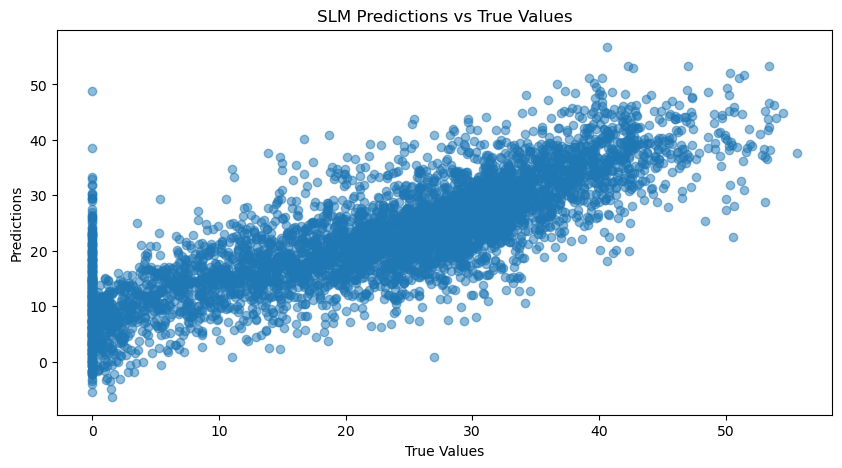

In [15]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt
from libpysal.weights import Queen
from spreg import GM_Lag
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import torch

# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)

# 固定选取的变量
fixed_columns = [
    'c_percent Aged 10 to 14 years',
    'c_percent Aged 15 to 19 years',
    'c_percent Aged 20 to 24 years',
    'c_percent Aged 25 to 29 years',
    'c_percent Aged 30 to 34 years',
    'c_percent Aged 35 to 39 years',
    'c_percent Aged 40 to 44 years',
    'c_percent Aged 65 to 69 years',
    'c_percent Aged 70 to 74 years',
    'c_percent Aged 75 to 79 years',
    'c_percent Aged 80 to 84 years',
    'c_percent Aged 85 years and over',
    'c_percent mixed',
    'c_percent white',
    'c_percent 2. Professional occupations',
    'c_pop_density',
    'e_ndvi',
    'e_water',
    'e_trees',
    'e_grass',
    'e_bare',
    'c_percent asian',
    'c_percent black',
    'c_percent buddhist',
    'c_percent muslim',
    'c_percent no central heating',
    'c_percent communal heating',
    'c_percent TFW less than 2km',
    'c_percent 49 or more hours worked',
    'c_percent commute on foot',
    'c_percent commute metro rail',
    'c_percent commute bus',
    'c_percent commute bicycle',
    'c_percent student moved to address',
    'c_percent occupancy rating bedrooms -2',
    'c_percent occupancy rating bedrooms -1',
    'c_percent 10 years or more',
    'c_percent 2 years or more but less than 5 years',
    'c_percent 5 years or more but less than 10 years',
    'c_percent married or in a registered civil partnership married same sex',
    'c_percent married or in a registered civil partnership in a registered civil partnership',
    'c_percent separated but still legally married or still legally in a civil partnership separated but still in a registered civil partnership',
    'c_percent divorced or civil partnership dissolved formerly in a civil partnership now legally dissolved',
    'c_percent   cannot speak english well',
    'c_percent   cannot speak english',
    'c_percent households deprived in four dimensions'
]

# 提取固定变量
fixed_features = gdf[fixed_columns].apply(pd.to_numeric, errors='coerce')

# 使用邻接节点的均值填充空值
for i, row in fixed_features.iterrows():
    for col in fixed_columns:
        if pd.isna(row[col]):
            neighbor_indices = list(G.neighbors(i))
            if neighbor_indices:  # 确保有邻居
                neighbor_values = fixed_features.iloc[neighbor_indices][col]
                mean_value = neighbor_values.mean()
                if pd.isna(mean_value):
                    mean_value = fixed_features[col].mean()  # 如果邻居的均值还是nan，使用全局均值填充
                fixed_features.at[i, col] = mean_value
            else:
                fixed_features.at[i, col] = fixed_features[col].mean()  # 如果没有邻居，使用全局均值填充

# 再次检查是否有任何nan值
print("Remaining NaN count:", fixed_features.isna().sum().sum())

# 进行标准化
scaler = StandardScaler()
final_features_scaled = scaler.fit_transform(fixed_features)

# 准备目标变量
target_column = 'o_anxiety_quantity_per_capita'
target = gdf[target_column].apply(pd.to_numeric, errors='coerce').fillna(0).values

# 创建空间权重矩阵
w = Queen.from_dataframe(gdf)

# 构建空间滞后模型
model = GM_Lag(target, final_features_scaled, w=w)

# 模型预测
predictions = model.predy

# 计算评估指标
mse = mean_squared_error(target, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(target, predictions)
r2 = r2_score(target, predictions)

print(f'Spatial Lag Model - MSE: {mse:.4f}')
print(f'Spatial Lag Model - RMSE: {rmse:.4f}')
print(f'Spatial Lag Model - MAE: {mae:.4f}')
print(f'Spatial Lag Model - R²: {r2:.4f}')

# 可视化预测值与真实值的散点图
plt.figure(figsize=(10, 5))
plt.scatter(target, predictions, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('SLM Predictions vs True Values')
plt.show()

Remaining NaN count: 0
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[73]	valid_0's l2: 68.1174	valid_0's l1: 6.19892
LightGBM - MSE: 68.1174
LightGBM - RMSE: 8.2533
LightGBM - MAE: 6.1989
LightGBM - R²: 0.5816


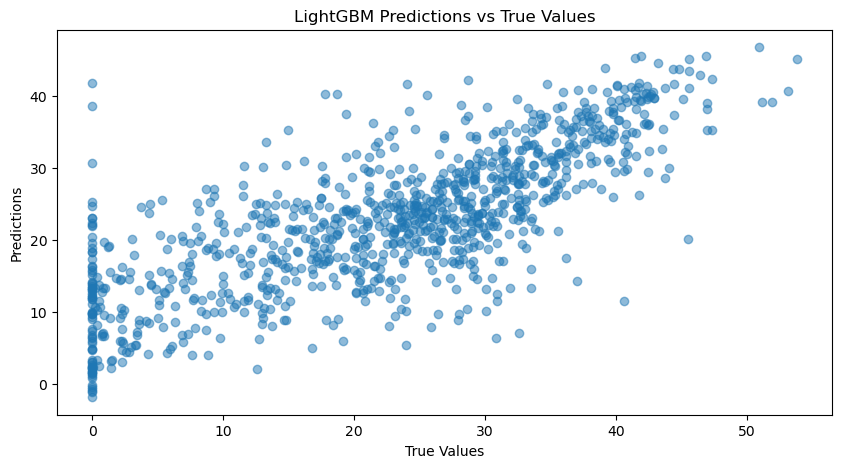

In [16]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)

# 固定选取的变量
fixed_columns = [
    'c_percent Aged 10 to 14 years',
    'c_percent Aged 15 to 19 years',
    'c_percent Aged 20 to 24 years',
    'c_percent Aged 25 to 29 years',
    'c_percent Aged 30 to 34 years',
    'c_percent Aged 35 to 39 years',
    'c_percent Aged 40 to 44 years',
    'c_percent Aged 65 to 69 years',
    'c_percent Aged 70 to 74 years',
    'c_percent Aged 75 to 79 years',
    'c_percent Aged 80 to 84 years',
    'c_percent Aged 85 years and over',
    'c_percent mixed',
    'c_percent white',
    'c_percent 2. Professional occupations',
    'c_pop_density',
    'e_ndvi',
    'e_water',
    'e_trees',
    'e_grass',
    'e_bare',
    'c_percent asian',
    'c_percent black',
    'c_percent buddhist',
    'c_percent muslim',
    'c_percent no central heating',
    'c_percent communal heating',
    'c_percent TFW less than 2km',
    'c_percent 49 or more hours worked',
    'c_percent commute on foot',
    'c_percent commute metro rail',
    'c_percent commute bus',
    'c_percent commute bicycle',
    'c_percent student moved to address',
    'c_percent occupancy rating bedrooms -2',
    'c_percent occupancy rating bedrooms -1',
    'c_percent 10 years or more',
    'c_percent 2 years or more but less than 5 years',
    'c_percent 5 years or more but less than 10 years',
    'c_percent married or in a registered civil partnership married same sex',
    'c_percent married or in a registered civil partnership in a registered civil partnership',
    'c_percent separated but still legally married or still legally in a civil partnership separated but still in a registered civil partnership',
    'c_percent divorced or civil partnership dissolved formerly in a civil partnership now legally dissolved',
    'c_percent   cannot speak english well',
    'c_percent   cannot speak english',
    'c_percent households deprived in four dimensions'
]

# 提取固定变量
fixed_features = gdf[fixed_columns].apply(pd.to_numeric, errors='coerce')

# 使用邻接节点的均值填充空值
for i, row in fixed_features.iterrows():
    for col in fixed_columns:
        if pd.isna(row[col]):
            neighbor_indices = list(G.neighbors(i))
            if neighbor_indices:  # 确保有邻居
                neighbor_values = fixed_features.iloc[neighbor_indices][col]
                mean_value = neighbor_values.mean()
                if pd.isna(mean_value):
                    mean_value = fixed_features[col].mean()  # 如果邻居的均值还是nan，使用全局均值填充
                fixed_features.at[i, col] = mean_value
            else:
                fixed_features.at[i, col] = fixed_features[col].mean()  # 如果没有邻居，使用全局均值填充

# 再次检查是否有任何nan值
print("Remaining NaN count:", fixed_features.isna().sum().sum())

# 进行标准化
scaler = StandardScaler()
final_features_scaled = scaler.fit_transform(fixed_features)

# 准备目标变量
target_column = 'o_anxiety_quantity_per_capita'
target = gdf[target_column].apply(pd.to_numeric, errors='coerce').fillna(0).values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(final_features_scaled, target, test_size=0.2, random_state=42)

# 创建LightGBM数据集
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 设置参数
params = {
    'objective': 'regression',
    'metric': ['l2', 'l1'],
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# 定义early stopping回调
callbacks = [lgb.early_stopping(stopping_rounds=10)]

# 训练模型
gbm = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data], callbacks=callbacks)

# 预测
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# 计算评估指标
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'LightGBM - MSE: {mse:.4f}')
print(f'LightGBM - RMSE: {rmse:.4f}')
print(f'LightGBM - MAE: {mae:.4f}')
print(f'LightGBM - R²: {r2:.4f}')

# 可视化预测值与真实值的散点图
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('LightGBM Predictions vs True Values')
plt.show()

C:\Users\0\AppData\Local\Temp\ipykernel_36820\2606480080.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geo_centroid'] = gdf.centroid


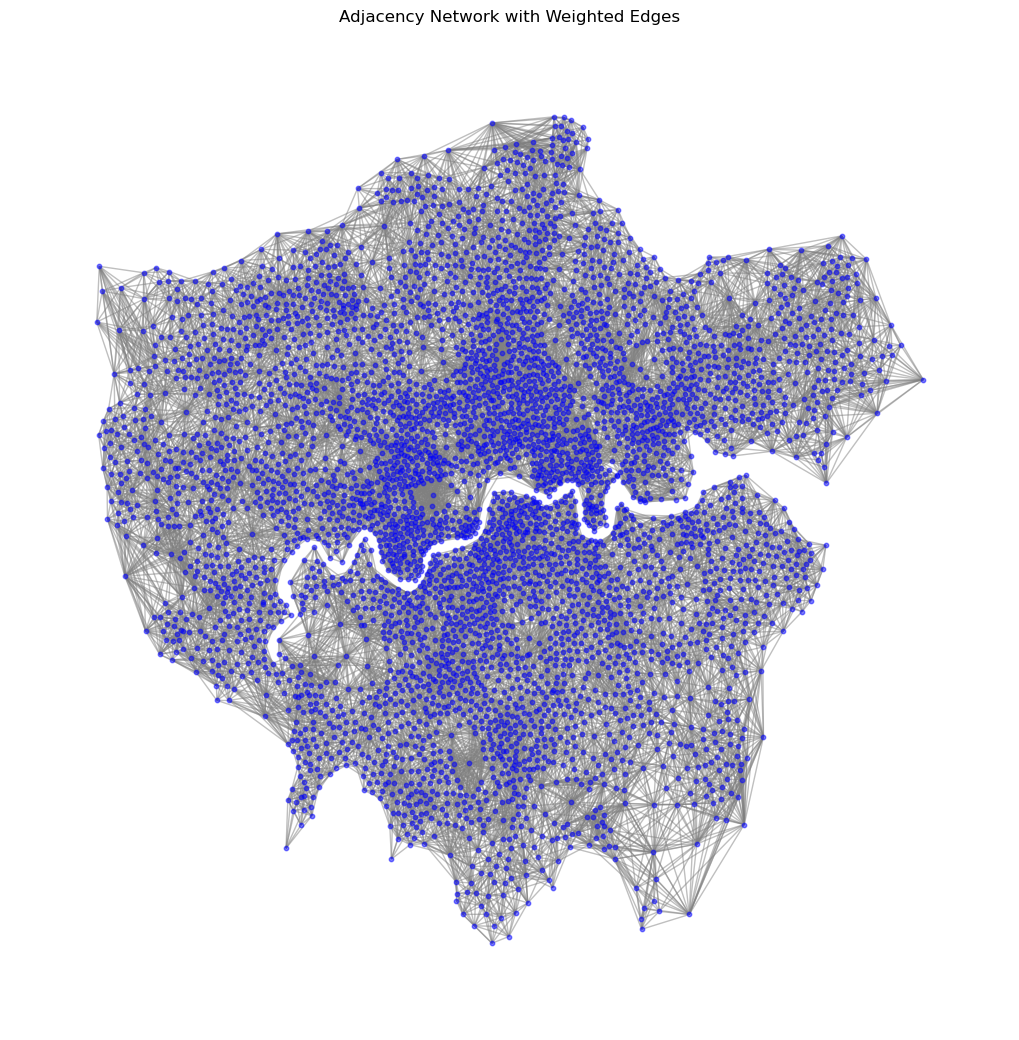

In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.utils import from_networkx
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# 读取CSV文件
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建GeoDataFrame
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)

# 计算几何中心点
gdf['geo_centroid'] = gdf.centroid
coords = np.array(list(zip(gdf.geo_centroid.x, gdf.geo_centroid.y)))

# 计算相邻关系
neighbors = gpd.sjoin(gdf, gdf, how='left', predicate='intersects')
neighbors = neighbors[neighbors.index != neighbors.index_right]

# 计算中心点之间的距离
dist_matrix = distance_matrix(coords, coords)

# 创建邻居关系字典
first_level_neighbors = {i: [] for i in range(len(gdf))}
second_level_neighbors = {i: set() for i in range(len(gdf))}

for idx, row in neighbors.iterrows():
    first_level_neighbors[row.name].append(row['index_right'])

# 查找第二层邻居
for i in first_level_neighbors:
    for first_neighbor in first_level_neighbors[i]:
        second_level_neighbors[i].update(first_level_neighbors[first_neighbor])
    second_level_neighbors[i].discard(i)
    second_level_neighbors[i].difference_update(first_level_neighbors[i])

# 构建网络并根据距离倒数设置权重
G = nx.Graph()

# 添加节点
for idx, row in gdf.iterrows():
    G.add_node(idx, pos=(row.geo_centroid.x, row.geo_centroid.y))

# 添加第一层邻居的边，权重高
for idx, neighbors in first_level_neighbors.items():
    for neighbor in neighbors:
        G.add_edge(idx, neighbor, weight=1 / dist_matrix[idx][neighbor])

# 添加第二层邻居的边，权重低
for idx, neighbors in second_level_neighbors.items():
    for neighbor in neighbors:
        G.add_edge(idx, neighbor, weight=0.5 / dist_matrix[idx][neighbor])  # 权重较低

# 可视化邻接关系
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network with Weighted Edges")
plt.show()

In [2]:
# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)

# 固定选取的变量
fixed_columns = [
    'c_percent Aged 10 to 14 years',
    'c_percent Aged 15 to 19 years',
    'c_percent Aged 20 to 24 years',
    'c_percent Aged 25 to 29 years',
    'c_percent Aged 30 to 34 years',
    'c_percent Aged 35 to 39 years',
    'c_percent Aged 40 to 44 years',
    'c_percent Aged 65 to 69 years',
    'c_percent Aged 70 to 74 years',
    'c_percent Aged 75 to 79 years',
    'c_percent Aged 80 to 84 years',
    'c_percent Aged 85 years and over',
    'c_percent mixed',
    'c_percent white',
    'c_percent 2. Professional occupations',
    'c_pop_density',
    'e_ndvi',
    'e_water',
    'e_trees',
    'e_grass',
    'e_bare',
    'c_percent asian',
    'c_percent black',
    'c_percent buddhist',
    'c_percent muslim',
    'c_percent no central heating',
    'c_percent communal heating',
    'c_percent TFW less than 2km',
    'c_percent 49 or more hours worked',
    'c_percent commute on foot',
    'c_percent commute metro rail',
    'c_percent commute bus',
    'c_percent commute bicycle',
    'c_percent student moved to address',
    'c_percent occupancy rating bedrooms -2',
    'c_percent occupancy rating bedrooms -1',
    # 'c_percent occupancy rating rooms -1',
    'c_percent 10 years or more',
    'c_percent 2 years or more but less than 5 years',
    'c_percent 5 years or more but less than 10 years',
    'c_percent married or in a registered civil partnership married same sex',
    'c_percent married or in a registered civil partnership in a registered civil partnership',
    # 'c_percent married or in a registered civil partnership in a registered civil partnership same sex',
    'c_percent separated but still legally married or still legally in a civil partnership separated but still in a registered civil partnership',
    'c_percent divorced or civil partnership dissolved formerly in a civil partnership now legally dissolved',
    'c_percent   cannot speak english well',
    'c_percent   cannot speak english',
    'c_percent households deprived in four dimensions'
]

# 提取固定变量
fixed_features = gdf[fixed_columns].apply(pd.to_numeric, errors='coerce')

# 使用邻接节点的均值填充空值
for i, row in fixed_features.iterrows():
    for col in fixed_columns:
        if pd.isna(row[col]):
            neighbor_indices = list(G.neighbors(i))
            if neighbor_indices:  # 确保有邻居
                neighbor_values = fixed_features.iloc[neighbor_indices][col]
                mean_value = neighbor_values.mean()
                if pd.isna(mean_value):
                    mean_value = fixed_features[col].mean()  # 如果邻居的均值还是nan，使用全局均值填充
                fixed_features.at[i, col] = mean_value
            else:
                fixed_features.at[i, col] = fixed_features[col].mean()  # 如果没有邻居，使用全局均值填充

# 再次检查是否有任何nan值
print("Remaining NaN count:", fixed_features.isna().sum().sum())

# 计算VIF
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Variable"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

vif_df = calculate_vif(fixed_features)
print(vif_df)

# 进行标准化
scaler = StandardScaler()
final_features_scaled = scaler.fit_transform(fixed_features)
final_features_tensor = torch.tensor(final_features_scaled, dtype=torch.float)

# 准备目标变量
target_column = 'o_anxiety_quantity_per_capita'
target = gdf[target_column].apply(pd.to_numeric, errors='coerce').fillna(0)
targets = torch.tensor(target.values, dtype=torch.float).unsqueeze(1)  # 添加维度以匹配模型输出

# 将 NetworkX 图转换为 PyTorch Geometric 数据
from torch_geometric.utils import from_networkx
data = from_networkx(G)
data.x = final_features_tensor
data.y = targets

Remaining NaN count: 0
                                             Variable         VIF
0                       c_percent Aged 10 to 14 years   45.952547
1                       c_percent Aged 15 to 19 years   17.553844
2                       c_percent Aged 20 to 24 years   34.235183
3                       c_percent Aged 25 to 29 years   36.637117
4                       c_percent Aged 30 to 34 years   57.487355
5                       c_percent Aged 35 to 39 years   72.134061
6                       c_percent Aged 40 to 44 years   72.721801
7                       c_percent Aged 65 to 69 years   34.952682
8                       c_percent Aged 70 to 74 years   33.932029
9                       c_percent Aged 75 to 79 years   26.678872
10                      c_percent Aged 80 to 84 years   19.878863
11                   c_percent Aged 85 years and over   10.233184
12                                    c_percent mixed   21.422281
13                                    c_percent white

Early stopping at epoch 43
Early stopping at epoch 193
Early stopping at epoch 52
Best params: {'lr': 0.005, 'weight_decay': 0.001, 'hidden1': 64, 'hidden2': 32, 'dropout': 0.5, 'num_epochs': 200}, Best loss: 44.5894
MSE: 43.7327
RMSE: 6.6131
MAE: 4.8505
R²: 0.7348


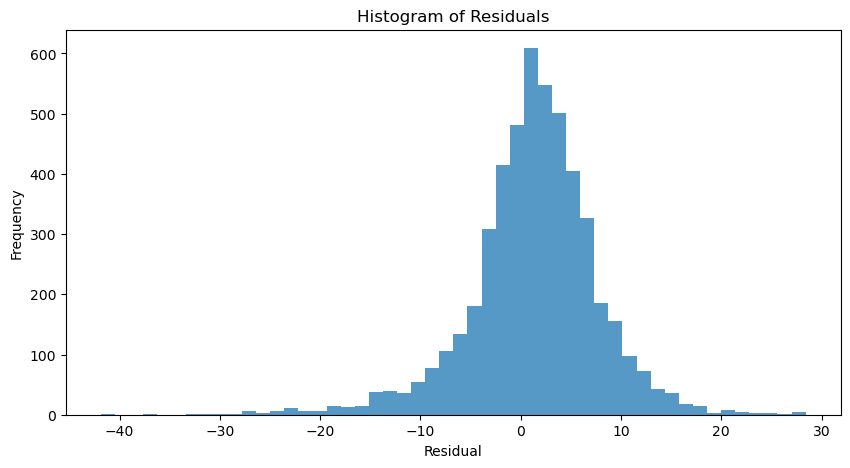

In [8]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import torch.nn.functional as F
import torch.optim as optim
import random
import itertools
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 定义GAT模型
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden1, heads=8, dropout=dropout)
        self.conv2 = GATConv(hidden1 * 8, hidden2, heads=8, dropout=dropout)
        self.fc1 = torch.nn.Linear(hidden2 * 8, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc1(x)
        return x

# 训练函数
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 训练函数，包含早停和学习率调度
def train_with_early_stopping(model, optimizer, scheduler, data, patience=10, num_epochs=200):
    best_loss = float('inf')
    best_epoch = 0
    no_improvement = 0
    losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_loss = F.mse_loss(model(data), data.y).item()

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    return best_loss, best_epoch, losses

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005],
    'weight_decay': [5e-4, 1e-3],
    'hidden1': [32, 64],
    'hidden2': [16, 32],
    'dropout': [0.3, 0.5],
    'num_epochs': [100, 200]
}

# 随机搜索
num_samples = 5  # 减少搜索空间
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GAT(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=data.y.shape[1], 
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

    loss, best_epoch, losses = train_with_early_stopping(model, optimizer, scheduler, data, patience=10, num_epochs=params['num_epochs'])

    if loss < best_loss:
        best_loss = loss
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GAT(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)
    scheduler.step(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


In [9]:
# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)

# 计算每个LSOA的几何中心点
gdf['geo_centroid'] = gdf.centroid

# 计算相邻关系
neighbors = gpd.sjoin(gdf, gdf, how='left', predicate='intersects')

# 手动处理索引
neighbors = neighbors[neighbors.index != neighbors.index_right]

# 构建邻接矩阵
G = nx.Graph()

# 添加节点
for idx, row in gdf.iterrows():
    G.add_node(idx, pos=(row.geo_centroid.x, row.geo_centroid.y))

# 添加边，根据相邻关系
for idx, row in neighbors.iterrows():
    G.add_edge(row.name, row['index_right'], weight=1)

# 可视化邻接关系
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network")
plt.show()

C:\Users\0\anaconda3\envs\envGEOG0051\Lib\site-packages\shapely\constructive.py:285: RuntimeWarning: invalid value encountered in centroid
  return lib.centroid(geometry, **kwargs)


GEOSException: UnsupportedOperationException: getX called on empty Point


Early stopping at epoch 34
Best params: {'lr': 0.005, 'weight_decay': 0.0005, 'hidden1': 64, 'hidden2': 16, 'dropout': 0.3, 'num_epochs': 200}, Best loss: 38.3421
MSE: 39.4978
RMSE: 6.2847
MAE: 4.5672
R²: 0.7605


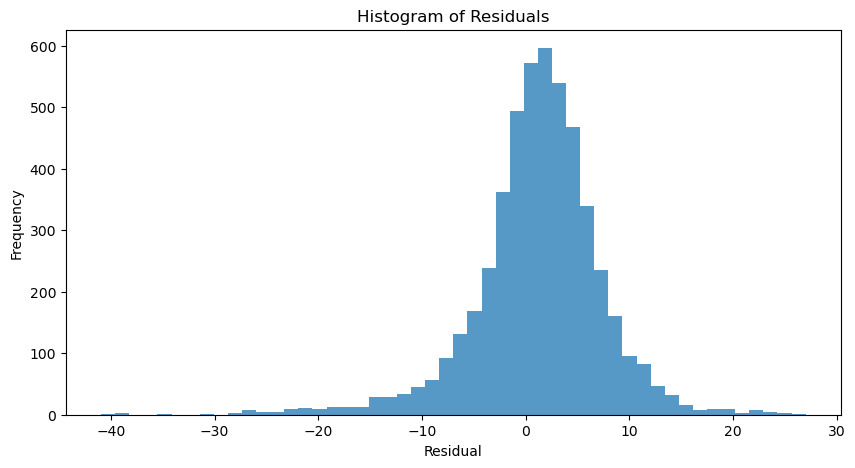

In [10]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import torch.nn.functional as F
import torch.optim as optim
import random
import itertools
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 定义GAT模型
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden1, heads=8, dropout=dropout)
        self.conv2 = GATConv(hidden1 * 8, hidden2, heads=8, dropout=dropout)
        self.fc1 = torch.nn.Linear(hidden2 * 8, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc1(x)
        return x

# 训练函数
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 训练函数，包含早停和学习率调度
def train_with_early_stopping(model, optimizer, scheduler, data, patience=10, num_epochs=200):
    best_loss = float('inf')
    best_epoch = 0
    no_improvement = 0
    losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_loss = F.mse_loss(model(data), data.y).item()

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    return best_loss, best_epoch, losses

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005],
    'weight_decay': [5e-4, 1e-3],
    'hidden1': [32, 64],
    'hidden2': [16, 32],
    'dropout': [0.3, 0.5],
    'num_epochs': [100, 200]
}

# 随机搜索
num_samples = 5  # 减少搜索空间
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GAT(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=data.y.shape[1], 
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

    loss, best_epoch, losses = train_with_early_stopping(model, optimizer, scheduler, data, patience=10, num_epochs=params['num_epochs'])

    if loss < best_loss:
        best_loss = loss
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GAT(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)
    scheduler.step(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

## IVAIC

C:\Users\0\AppData\Local\Temp\ipykernel_33036\75027981.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geo_centroid'] = gdf.geometry.centroid


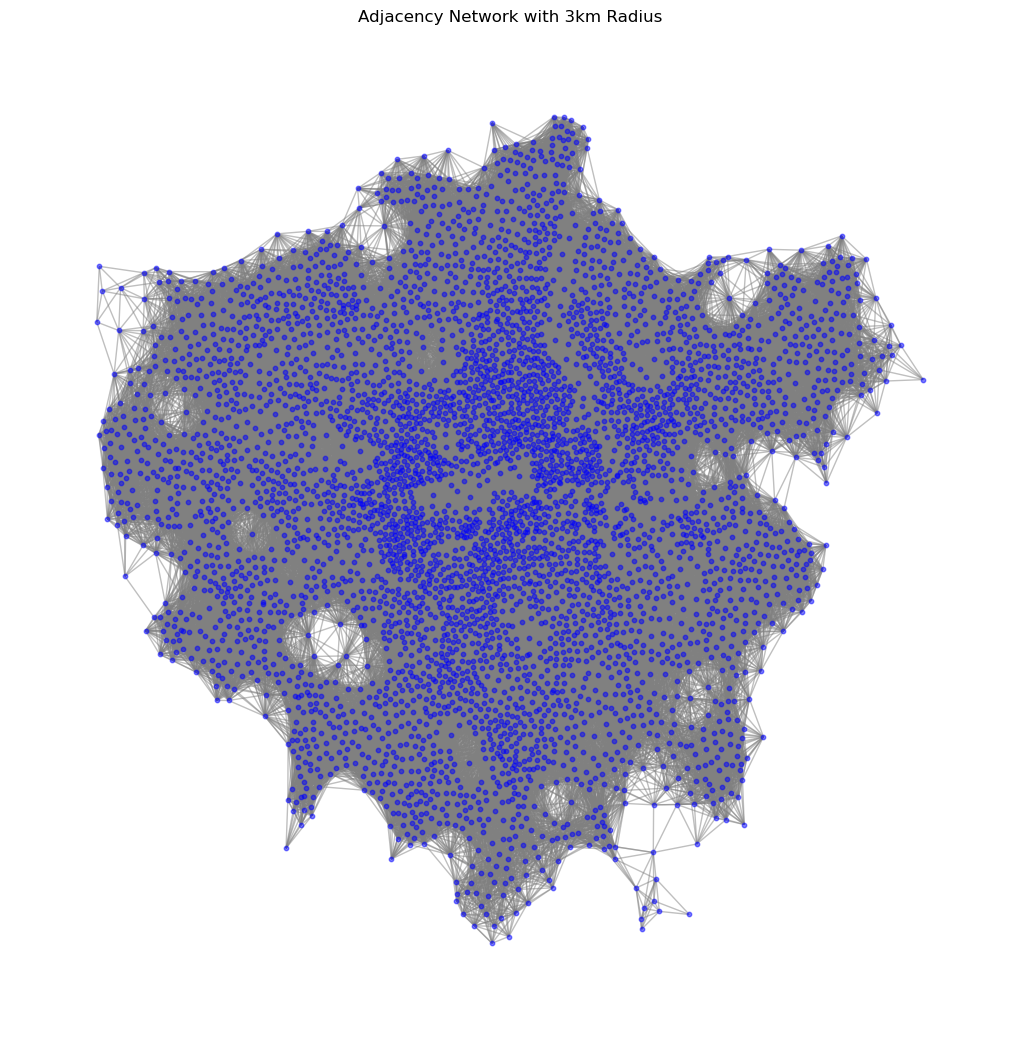

In [11]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import Point

# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# 设置坐标系 (假设是WGS84坐标系)，然后转换为投影坐标系 (例如EPSG:32630 - WGS 84 / UTM zone 30N)
gdf.set_crs(epsg=4326, inplace=True)

# 计算几何中心点
gdf['geo_centroid'] = gdf.geometry.centroid

# 设置邻接半径（例如3公里）
radius = 3000  # 3公里

# 构建图
G = nx.Graph()

# 添加节点
for idx, row in gdf.iterrows():
    G.add_node(idx, pos=(row.geo_centroid.x, row.geo_centroid.y))

# 使用空间索引来加速邻居查询
gdf['geometry'] = gdf['geo_centroid']
gdf = gdf.set_geometry('geometry')
sindex = gdf.sindex

# 添加边，根据预定义的半径
for idx, row in gdf.iterrows():
    point = row.geometry
    possible_neighbors = list(sindex.intersection(point.buffer(radius).bounds))
    for neighbor_idx in possible_neighbors:
        if neighbor_idx != idx:
            neighbor = gdf.iloc[neighbor_idx].geometry
            if point.distance(neighbor) <= radius:
                G.add_edge(idx, neighbor_idx, weight=1)

# 可视化邻接关系
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network with 3km Radius")
plt.show()


C:\Users\0\AppData\Local\Temp\ipykernel_24040\2930676820.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geo_centroid'] = gdf.centroid


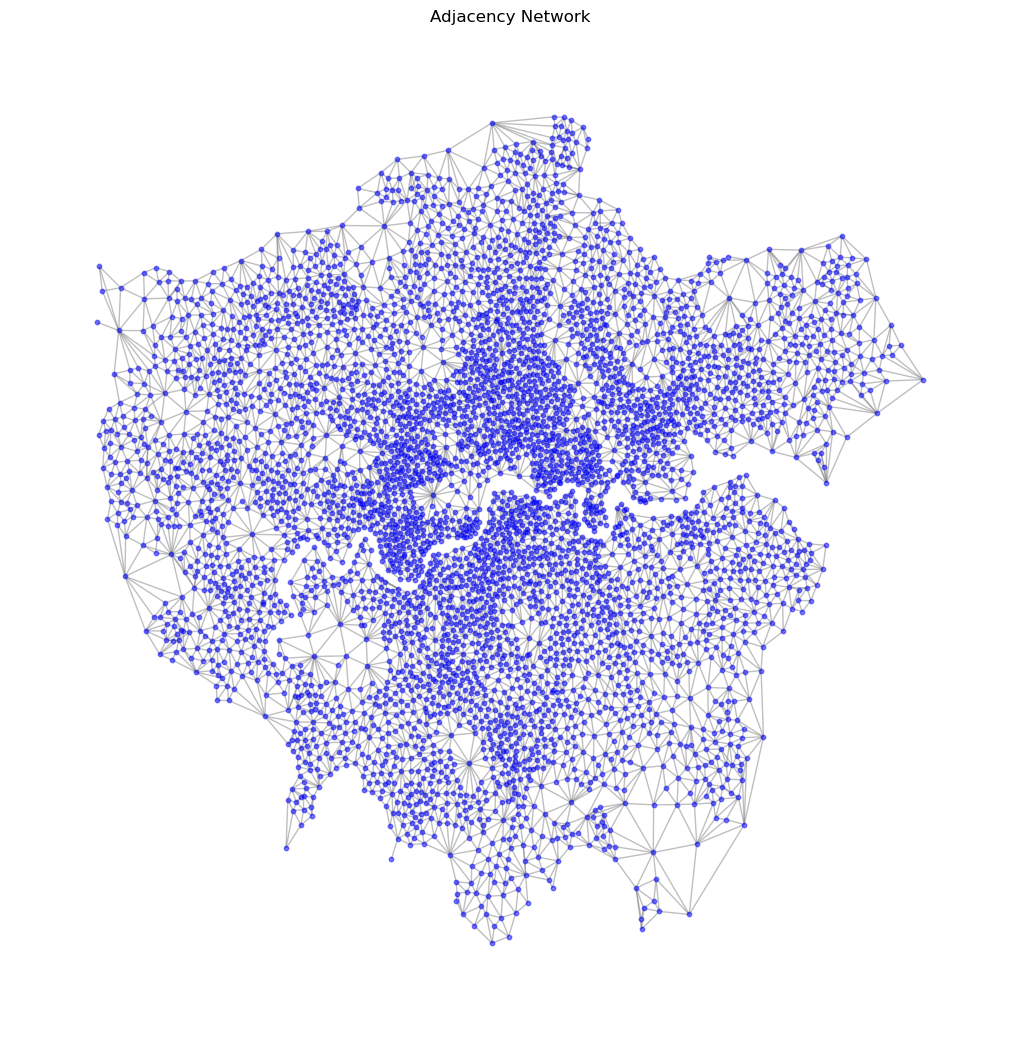

In [6]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import Point
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, global_add_pool
from torch_geometric.utils import from_networkx
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)

# 计算每个LSOA的几何中心点
gdf['geo_centroid'] = gdf.centroid

# 计算相邻关系
neighbors = gpd.sjoin(gdf, gdf, how='left', predicate='intersects')

# 手动处理索引
neighbors = neighbors[neighbors.index != neighbors.index_right]

# 构建邻接矩阵
G = nx.Graph()

# 添加节点
for idx, row in gdf.iterrows():
    G.add_node(idx, pos=(row.geo_centroid.x, row.geo_centroid.y))

# 添加边，根据相邻关系
for idx, row in neighbors.iterrows():
    G.add_edge(row.name, row['index_right'], weight=1)

# 可视化邻接关系
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network")
plt.show()

In [7]:
# 固定选取的变量
fixed_columns = [
    'c_percent Aged 10 to 14 years',
    'c_percent Aged 15 to 19 years',
    'c_percent Aged 20 to 24 years',
    'c_percent Aged 25 to 29 years',
    'c_percent Aged 30 to 34 years',
    'c_percent Aged 35 to 39 years',
    'c_percent Aged 40 to 44 years',
    'c_percent Aged 65 to 69 years',
    'c_percent Aged 70 to 74 years',
    'c_percent Aged 75 to 79 years',
    'c_percent Aged 80 to 84 years',
    'c_percent Aged 85 years and over',
    'c_percent mixed',
    'c_percent white',
    'c_percent 2. Professional occupations',
    'c_pop_density',
    'e_ndvi',
    'e_water',
    'e_trees',
    'e_grass',
    'e_bare',
    'c_percent asian',
    'c_percent black',
    'c_percent buddhist',
    'c_percent muslim',
    'c_percent no central heating',
    'c_percent communal heating',
    'c_percent TFW less than 2km',
    'c_percent 49 or more hours worked',
    'c_percent commute on foot',
    'c_percent commute metro rail',
    'c_percent commute bus',
    'c_percent commute bicycle',
    'c_percent student moved to address',
    'c_percent occupancy rating bedrooms -2',
    'c_percent occupancy rating bedrooms -1',
    'c_percent 10 years or more',
    'c_percent 2 years or more but less than 5 years',
    'c_percent 5 years or more but less than 10 years',
    'c_percent married or in a registered civil partnership married same sex',
    'c_percent married or in a registered civil partnership in a registered civil partnership',
    'c_percent separated but still legally married or still legally in a civil partnership separated but still in a registered civil partnership',
    'c_percent divorced or civil partnership dissolved formerly in a civil partnership now legally dissolved',
    'c_percent   cannot speak english well',
    'c_percent   cannot speak english',
    'c_percent households deprived in four dimensions'
]

# 提取固定变量
fixed_features = gdf[fixed_columns].apply(pd.to_numeric, errors='coerce')

# 使用邻接节点的均值填充空值
for i, row in fixed_features.iterrows():
    for col in fixed_columns:
        if pd.isna(row[col]):
            neighbor_indices = list(G.neighbors(i))
            if neighbor_indices:  # 确保有邻居
                neighbor_values = fixed_features.iloc[neighbor_indices][col]
                mean_value = neighbor_values.mean()
                if pd.isna(mean_value):
                    mean_value = fixed_features[col].mean()  # 如果邻居的均值还是nan，使用全局均值填充
                fixed_features.at[i, col] = mean_value
            else:
                fixed_features.at[i, col] = fixed_features[col].mean()  # 如果没有邻居，使用全局均值填充

# 再次检查是否有任何nan值
print("Remaining NaN count:", fixed_features.isna().sum().sum())

# 计算VIF
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Variable"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

vif_df = calculate_vif(fixed_features)
print(vif_df)

# 进行标准化
scaler = StandardScaler()
final_features_scaled = scaler.fit_transform(fixed_features)
final_features_tensor = torch.tensor(final_features_scaled, dtype=torch.float)

# 准备目标变量
target_column = 'o_anxiety_quantity_per_capita'
target = gdf[target_column].apply(pd.to_numeric, errors='coerce').fillna(0)
targets = torch.tensor(target.values, dtype=torch.float).unsqueeze(1)  # 添加维度以匹配模型输出

# 将 NetworkX 图转换为 PyTorch Geometric 数据
data = from_networkx(G)
data.x = final_features_tensor
data.y = targets

Remaining NaN count: 0
                                             Variable         VIF
0                       c_percent Aged 10 to 14 years   45.952547
1                       c_percent Aged 15 to 19 years   17.553844
2                       c_percent Aged 20 to 24 years   34.235183
3                       c_percent Aged 25 to 29 years   36.637117
4                       c_percent Aged 30 to 34 years   57.487355
5                       c_percent Aged 35 to 39 years   72.134061
6                       c_percent Aged 40 to 44 years   72.721801
7                       c_percent Aged 65 to 69 years   34.952682
8                       c_percent Aged 70 to 74 years   33.932029
9                       c_percent Aged 75 to 79 years   26.678872
10                      c_percent Aged 80 to 84 years   19.878863
11                   c_percent Aged 85 years and over   10.233184
12                                    c_percent mixed   21.422281
13                                    c_percent white

Epoch 0, Training Loss: 682.9711, Validation Loss: 671.6675
Epoch 10, Training Loss: 546.6562, Validation Loss: 537.6338
Epoch 20, Training Loss: 296.5363, Validation Loss: 280.8488
Epoch 30, Training Loss: 188.2099, Validation Loss: 123.6717
Epoch 40, Training Loss: 142.4018, Validation Loss: 128.2452
Early stopping at epoch 44
Epoch 0, Training Loss: 675.2487, Validation Loss: 663.8279
Epoch 10, Training Loss: 530.7339, Validation Loss: 518.9992
Epoch 20, Training Loss: 253.9324, Validation Loss: 233.8420
Epoch 30, Training Loss: 194.1000, Validation Loss: 119.0220
Epoch 40, Training Loss: 149.7964, Validation Loss: 132.5583
Early stopping at epoch 41
Epoch 0, Training Loss: 671.3071, Validation Loss: 617.1935
Epoch 10, Training Loss: 148.5190, Validation Loss: 105.5865
Epoch 20, Training Loss: 121.2441, Validation Loss: 95.0165
Epoch 30, Training Loss: 102.9287, Validation Loss: 79.4175
Epoch 40, Training Loss: 95.4098, Validation Loss: 78.2491
Epoch 50, Training Loss: 94.5941, Vali

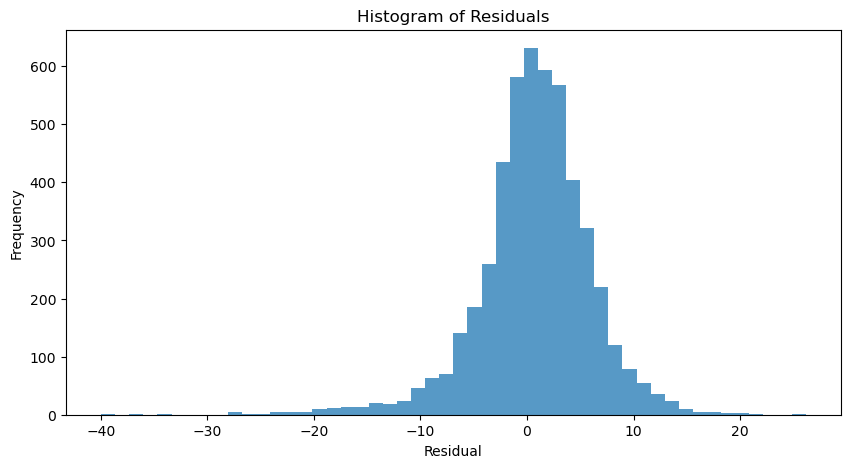

In [8]:
# 定义GATv2模型
class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=8, dropout=dropout)
        self.conv2 = GATv2Conv(hidden1 * 8, hidden2, heads=8, dropout=dropout)
        self.fc1 = torch.nn.Linear(hidden2 * 8, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc1(x)
        return x

# 训练函数
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 训练函数，包含早停和学习率调度
def train_with_early_stopping(model, optimizer, scheduler, data, patience=10, num_epochs=200, print_every=10):
    best_loss = float('inf')
    best_epoch = 0
    no_improvement = 0
    losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_loss = F.mse_loss(model(data), data.y).item()

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch
            no_improvement = 0
        else:
            no_improvement += 1

        if epoch % print_every == 0:
            print(f"Epoch {epoch}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}")

        if no_improvement >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    return best_loss, best_epoch, losses

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005],
    'weight_decay': [5e-4, 1e-3],
    'hidden1': [32, 64],
    'hidden2': [16, 32],
    'dropout': [0.3, 0.5],
    'num_epochs': [100, 200]
}

# 随机搜索
num_samples = 10  # 减少搜索空间
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GATv2(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=data.y.shape[1], 
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

    loss, best_epoch, losses = train_with_early_stopping(model, optimizer, scheduler, data, patience=10, num_epochs=params['num_epochs'])

    if loss < best_loss:
        best_loss = loss
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GATv2(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)
    scheduler.step(loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [21]:
best_params = {'lr': 0.005,
 'weight_decay': 0.001,
 'hidden1': 64,
 'hidden2': 16,
 'dropout': 0.5,
 'num_epochs': 200}

Epoch 0, Loss: 675.0813
Epoch 10, Loss: 127.7831
Epoch 20, Loss: 114.6807
Epoch 30, Loss: 101.3102
Epoch 40, Loss: 97.9052
Epoch 50, Loss: 93.7086
Epoch 60, Loss: 91.2486
Epoch 70, Loss: 88.1382
Epoch 80, Loss: 84.6403
Epoch 90, Loss: 84.8143
Epoch 100, Loss: 78.1838
Epoch 110, Loss: 76.0837
Epoch 120, Loss: 74.5687
Epoch 130, Loss: 71.1334
Epoch 140, Loss: 67.1942
Epoch 150, Loss: 66.6595
Epoch 160, Loss: 62.2779
Epoch 170, Loss: 63.7052
Epoch 180, Loss: 58.4784
Epoch 190, Loss: 59.9933
MSE: 42.4901
RMSE: 6.5184
MAE: 4.8460
R²: 0.7424


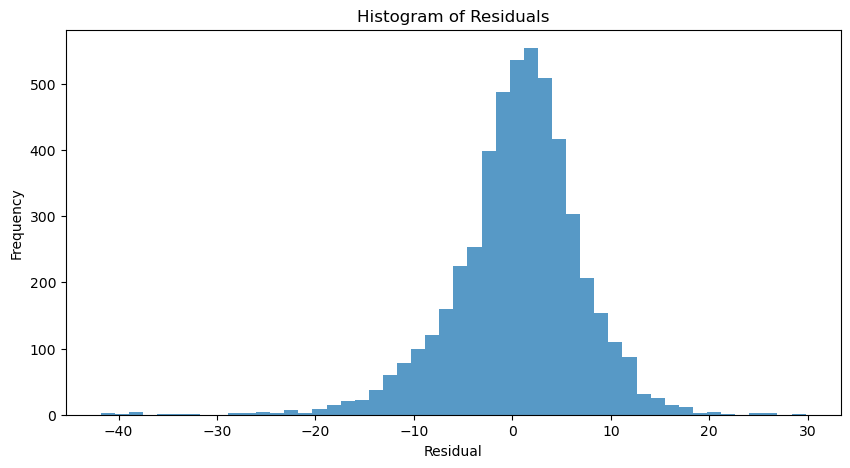

In [22]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import torch.nn.functional as F
import torch.optim as optim
import random
import itertools
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 使用最佳超参数重新训练模型
model = GATv2(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)
    scheduler.step(loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()